In [1]:
%reload_ext nb_black

<IPython.core.display.Javascript object>

## Day 24 Lecture 1 Assignment

In this assignment, we will build our first logistic regression model on numeric data. We will use the FIFA soccer ratings dataset loaded below and analyze the model generated for this dataset.

In [2]:
import numpy as np
import pandas as pd

import statsmodels.api as sm
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.calibration import calibration_curve

import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

<IPython.core.display.Javascript object>

In [3]:
def remove_correlated_features(dataset, threshold=0.9):
    col_corr = set()
    corr_matrix = dataset.corr()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if (corr_matrix.iloc[i, j] >= threshold) and (
                corr_matrix.columns[j] not in col_corr
            ):
                colname = corr_matrix.columns[i]
                col_corr.add(colname)
                if colname in dataset.columns:
                    print(f"Deleted {colname} from dataset.")
                    del dataset[colname]

    return dataset

<IPython.core.display.Javascript object>

In [4]:
soccer_data = pd.read_csv(
    "https://tf-assets-prod.s3.amazonaws.com/tf-curric/data-science/fifa_ratings.csv"
)

<IPython.core.display.Javascript object>

In [18]:
soccer_data.sort_values(by="Overall", ascending=False).head()

,ID,Name,Overall,Crossing,Finishing,HeadingAccuracy,ShortPassing,Volleys,Dribbling,Curve,...,Aggression,Interceptions,Positioning,Vision,Penalties,Composure,Marking,StandingTackle,SlidingTackle,is_elite
0,158023,L. Messi,94,84,95,70,90,86,97,93,...,48,22,94,94,75,96,33,28,26,1
1,20801,Cristiano Ronaldo,94,84,94,89,81,87,88,81,...,63,29,95,82,85,95,28,31,23,1
2,190871,Neymar Jr,92,79,87,62,84,84,96,88,...,56,36,89,87,81,94,27,24,33,1
3,192985,K. De Bruyne,91,93,82,55,92,82,86,85,...,76,61,87,94,79,88,68,58,51,1
4,183277,E. Hazard,91,81,84,61,89,80,95,83,...,54,41,87,89,86,91,34,27,22,1


<IPython.core.display.Javascript object>

In [5]:
soccer_data.head()

,ID,Name,Overall,Crossing,Finishing,HeadingAccuracy,ShortPassing,Volleys,Dribbling,Curve,...,LongShots,Aggression,Interceptions,Positioning,Vision,Penalties,Composure,Marking,StandingTackle,SlidingTackle
0,158023,L. Messi,94,84,95,70,90,86,97,93,...,94,48,22,94,94,75,96,33,28,26
1,20801,Cristiano Ronaldo,94,84,94,89,81,87,88,81,...,93,63,29,95,82,85,95,28,31,23
2,190871,Neymar Jr,92,79,87,62,84,84,96,88,...,82,56,36,89,87,81,94,27,24,33
3,192985,K. De Bruyne,91,93,82,55,92,82,86,85,...,91,76,61,87,94,79,88,68,58,51
4,183277,E. Hazard,91,81,84,61,89,80,95,83,...,80,54,41,87,89,86,91,34,27,22


<IPython.core.display.Javascript object>

Our response for our logistic regression model is going to be a binary label, "Elite" or "Not Elite", corresponding to whether or not the player has an overall rating greater than or equal to 75. This corresponds to the top 10% or so of soccer players in the data set. Create the response column.

In [6]:
soccer_data["is_elite"] = soccer_data["Overall"] >= 75
soccer_data["is_elite"] = soccer_data["is_elite"].astype(int)
soccer_data["is_elite"].value_counts()

0    14251
1     1871
Name: is_elite, dtype: int64

<IPython.core.display.Javascript object>

Address potential collinearity issues by removing the appropriate features. There is no universally agreed upon technique for doing so, so feel free to use any reasonable method. We have provided the convenience function *remove_correlated_features* at the top as one way of doing so, and we use a threshold of 0.9 for that function to reduce correlation among features.

In [7]:
X = soccer_data.drop(columns=["ID", "is_elite", "Overall", "Name"])
y = soccer_data["is_elite"]

<IPython.core.display.Javascript object>

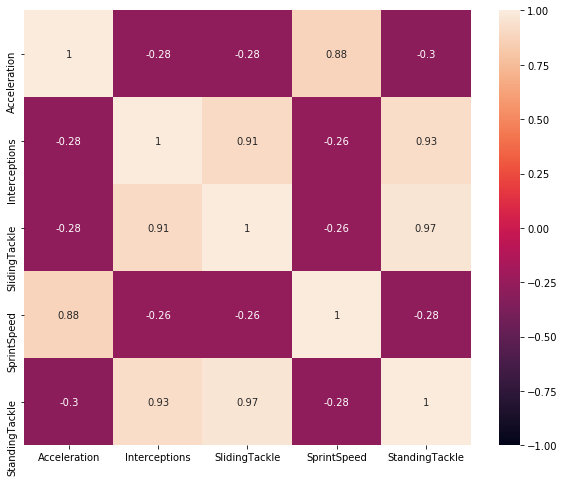

<IPython.core.display.Javascript object>

In [8]:
plot_corr_thresh = 0.875

corrs = X.corr()
np.fill_diagonal(corrs.values, np.nan)
row_filter, col_filter = np.where(corrs.abs() > plot_corr_thresh)

# This ends up with duplicate rows and columns
hi_corrs = corrs.iloc[row_filter, col_filter]

# Remove duplicate rows, then remove duplicate columns after transposing
hi_corrs = hi_corrs.drop_duplicates().T.drop_duplicates()
hi_corrs = hi_corrs.fillna(1.0)
hi_corrs = hi_corrs.sort_index(axis="rows")
hi_corrs = hi_corrs.sort_index(axis="columns")

plt.figure(figsize=(10, 8))
sns.heatmap(hi_corrs, annot=True, vmin=-1, vmax=1)
plt.show()

In [9]:
X = remove_correlated_features(X, 0.9)

Deleted StandingTackle from dataset.
Deleted SlidingTackle from dataset.


<IPython.core.display.Javascript object>

Split the data into train and test, with 80% training and 20% testing. Be sure to leave out columns that would not make sense in the model, like the player ID column.

In [10]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

<IPython.core.display.Javascript object>

Fit the logistic regression model using the statsmodels package and print out the coefficient summary. Which variables appear to be the most important, and what effect do they have on the probability of a player being elite?

### `sklearn`

In [11]:
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

<IPython.core.display.Javascript object>

In [12]:
model.score(X_train, y_train)

0.9573544235093433

<IPython.core.display.Javascript object>

In [13]:
model.score(X_test, y_test)

0.9621705426356589

<IPython.core.display.Javascript object>

In [14]:
y_pred = model.predict(X_test)

conf_mat = confusion_matrix(y_test, y_pred)
conf_df = pd.DataFrame(
    conf_mat, columns=["Predicted 0", "Predicted 1"], index=["Actual 0", "Actual 1"]
)
conf_df

,Predicted 0,Predicted 1
Actual 0,2822,41
Actual 1,81,281


<IPython.core.display.Javascript object>

In [15]:
coef_df = pd.DataFrame({"feat": X.columns, "coef": model.coef_.flatten()})
coef_df.head()

,feat,coef
0,Crossing,-0.017579
1,Finishing,0.027437
2,HeadingAccuracy,0.049359
3,ShortPassing,0.187062
4,Volleys,-0.018890


<IPython.core.display.Javascript object>

### `statsmodels`

In [16]:
X_train_const = sm.add_constant(X_train)
X_test_const = sm.add_constant(X_test)

sm_model = sm.Logit(y_train, X_train_const).fit()
print(sm_model.summary())

Optimization terminated successfully.
         Current function value: 0.105116
         Iterations 10
                           Logit Regression Results                           
Dep. Variable:               is_elite   No. Observations:                12897
Model:                          Logit   Df Residuals:                    12869
Method:                           MLE   Df Model:                           27
Date:                Thu, 27 Aug 2020   Pseudo R-squ.:                  0.7088
Time:                        09:58:39   Log-Likelihood:                -1355.7
converged:                       True   LL-Null:                       -4654.7
Covariance Type:            nonrobust   LLR p-value:                     0.000
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const             -58.3055      1.759    -33.143      0.000     -61.753     -54.857
Crossing     

<IPython.core.display.Javascript object>

In [19]:
y_pred = sm_model.predict(X_test_const)
y_pred = y_pred > 0.5

conf_mat = confusion_matrix(y_test, y_pred)
conf_df = pd.DataFrame(
    conf_mat, columns=["Predicted 0", "Predicted 1"], index=["Actual 0", "Actual 1"]
)
conf_df

,Predicted 0,Predicted 1
Actual 0,2822,41
Actual 1,81,281


<IPython.core.display.Javascript object>

We have yet to discuss how to evaluate the model, which will happen next week, but one intuitive way to see if our model predictions are reasonable is to plot a calibration curve. In essence, the probabilities predicted by a good model will match the observed proportions of outcomes (i.e. If we take all of the predictions around 70% made by our model, the corresponding observed outcomes should be Elite about 70% of the time).

First, make predictions on the test set and join them to the corresponding true outcomes. Then, use the *calibration_curve* function in scikit learn to plot a calibration curve. What do you see?

There is some helpful code for creating calibration plots at the link below:
https://scikit-learn.org/stable/auto_examples/calibration/plot_calibration_curve.html#sphx-glr-auto-examples-calibration-plot-calibration-curve-py

In [20]:
y_pred_prob = model.predict_proba(X_test)[:, 1]  # sklearn
# y_pred_prob = sm_model.predict(X_test_const)  # statsmodels




<IPython.core.display.Javascript object>

We're predicting a probability of an observation being class 1.
When the model says it has 100% certainty that an observation is
a 1 and it's wrong, we wouldn't think it knows what it's talking about.
If the model says it has 99% certainty 100 times and its wrong on one
prediction, then we'd say it really knows what it talks about.  This
is what a calibration curve is showing.  It will look at all the times the
model predicted a 50% chance of class 1, a well calibrated model should end up
with 50% accuracy when it's 50% confident. (out of all our 10% probability
predictions we should see 10% of the related observations being a class 1; 20% etc.)

In [21]:
# Example manually calculating calibration

# I'm rounding because its easy to do, sklearn will
# bin in a more general way (i.e. so we can ask for 10 bins or 15)
# This will lead to some differences in results
calibration_df = pd.DataFrame(
    {"rounded_prob_class_1": np.round(y_pred_prob, 1), "label": y_test}
)

# For each level of prob, find percentage of true class 1s
# (also counting how many total obs at that level)
calibration_df = calibration_df.groupby("rounded_prob_class_1").agg(["mean", "size"])
calibration_df = calibration_df.reset_index()
calibration_df.columns = ["rounded_prob_class_1", "perc_class_1", "n_obs"]
calibration_df.head()

,rounded_prob_class_1,perc_class_1,n_obs
0,0.0,0.003143,2545
1,0.1,0.110429,163
2,0.2,0.160000,75
3,0.3,0.318182,44
4,0.4,0.361702,47


<IPython.core.display.Javascript object>

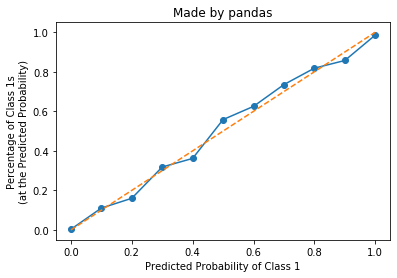

<IPython.core.display.Javascript object>

In [22]:
x = calibration_df["rounded_prob_class_1"]
y = calibration_df["perc_class_1"]

plt.plot(x, y, "-o")
plt.plot([0, 1], [0, 1], "--")
plt.title("Made by pandas")
plt.xlabel("Predicted Probability of Class 1")
plt.ylabel("Percentage of Class 1s\n(at the Predicted Probability)")
plt.show()

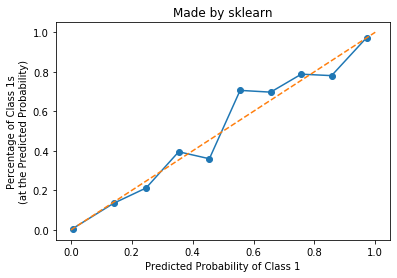

<IPython.core.display.Javascript object>

In [23]:
y, x = calibration_curve(y_test, y_pred_prob, n_bins=10)

plt.plot(x, y, "-o")
plt.plot([0, 1], [0, 1], "--")
plt.title("Made by sklearn")
plt.xlabel("Predicted Probability of Class 1")
plt.ylabel("Percentage of Class 1s\n(at the Predicted Probability)")
plt.show()

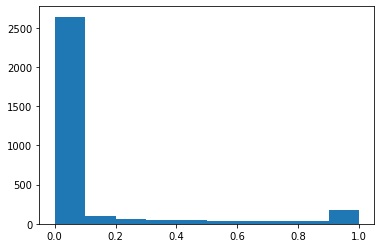

<IPython.core.display.Javascript object>

In [24]:
# Our poorer calibration in 0.4 - 0.8 range
# might be related to smaller samples.
# Our model was pretty confident most of the time
# (almost all predicted probabilities were very close to 0 or 1)
plt.hist(y_pred_prob)
plt.show()